# Laboratorio ANPI - Singular Value Decomposition (SVD)
### Prof. Pablo Soto
### Estudiantes Juan Pablo Rodríguez Cano - Eduardo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import time
import os
import glob

# SVD Reducida

In [2]:
def svdCompact(A):
    m, n = A.shape
    if m > n:
        M1 = A.T@A
        D, V = np.linalg.eig(M1)
        const = n*np.max(D)*2.22e-16
        y = (D>const)
        rA = np.sum(y)
        D = y*D
        idx = D.argsort()[::-1]   
        D = D[idx]
        V = V[idx]
        Vr = V[:,:rA]
        Sr = np.diag(D[:rA])
        Ur = (1/D[:rA])*(A@Vr)
    else:
        M1 = A@A.T
        D, V = np.linalg.eig(M1)
        const = n*np.max(D)*2.22e-16
        y = (D>const)
        rA = np.sum(y)
        D = y*D
        idx = D.argsort()[::-1]   
        D = D[idx]
        U = V[idx]
        Ur = U[:,:rA]
        Sr = np.diag(D[:rA])
        Vr = (1/D[:rA]).T@A@Ur
        
    return Vr, Sr, Ur

In [3]:
A = np.array([[2, 1, 2], [2, -2, 2], [-2, -1, -2], [2, 0, 2]])

In [4]:
print(svdCompact(A))

(array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678],
       [ 0.        ,  0.        ]]), array([[32.,  0.],
       [ 0.,  6.]]), array([[ 0.06629126, -0.11785113],
       [ 0.        , -0.47140452],
       [-0.06629126,  0.11785113],
       [ 0.04419417, -0.23570226]]))


In [5]:
def grafica_tiempos(A):
    dimensiones = range(5,13)
    tiempos_svd = []
    tiempos_svd_compacta = []
    for i in dimensiones:
        A = np.random.rand(i,i-1)
        start = time.time()
        np.linalg.svd(A)
        finish = time.time()
        svdCompact(A)
        finish2 = time.time()
        tiempos_svd.append(finish - start)
        tiempos_svd_compacta.append(finish2 - finish)
    
    plt.plot(dimensiones, tiempos_svd, 'r-',label="Numpy")
    plt.plot(dimensiones, tiempos_svd_compacta, 'b-', label="SVD Compacta")
    plt.title("Tiempos de ejecución de métodos de SVD")
    plt.xlabel("Dimensiones")
    plt.ylabel("Tiempo(s)")
    plt.legend()
    plt.grid()
    plt.show()

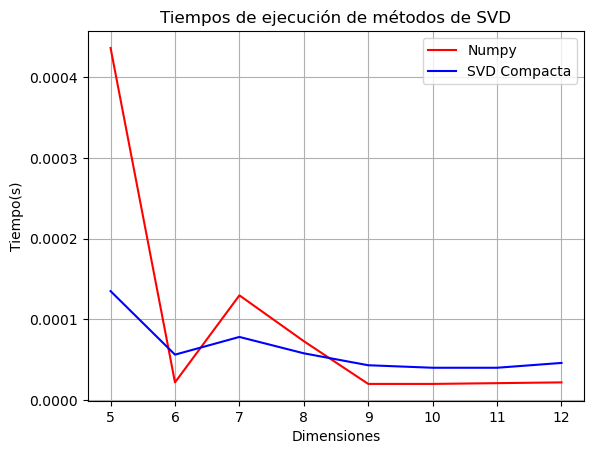

In [6]:
grafica_tiempos(A)

# Reconomientro facial de imágenes con SVD

## Inicializa valores

In [27]:
def inicializa_imagenes():
    """
    inicializa la matriz del conjuto de rostros de las imagenes de 112x92 pixeles (10304 pixeles en total) que
    corresponden a un vector columna por imagen.
    Return: matriz de rostros de entrenamiento y matriz de rostos de comparación
    """
    X_train = np.empty((10304, 360))
    X_compare = np.empty((10304, 40))
    
    training_folder = os.getcwd() + "/training"
    compare_folder = os.getcwd() + "/compare"
    
    idx=0
    
    pattern = os.path.join(compare_folder, "p*.jpg")
    files = glob.glob(pattern)
    
    for file in files:
        image = np.asarray(PIL.Image.open(file)).reshape(-1,1)
        X_compare[:,idx:idx+1] = image
        idx+=1
    
    idx=0
    
    for i in range(1, 41):
        subdirectory = os.path.join(training_folder, f"s{i}")
        pattern = os.path.join(subdirectory, "*.jpg")
        files = glob.glob(pattern)

        for file in files:
            image = np.asarray(PIL.Image.open(file)).reshape(-1,1)
            X_train[:,idx:idx+1] = image
            idx+=1
    return X_train, X_compare

In [9]:
X_train, X_compare = inicializa_imagenes()

#A todos los pixeles se le resta el valor promedio correspondiente de su fila
A_compare = X_compare - X_compare.mean(axis=1).reshape(-1,1)
A_train = X_train - X_train.mean(axis=1).reshape(-1,1)

In [10]:
#Decomposición de valores singulares
U, S, V = np.linalg.svd(A_train)

In [11]:
# Rango de A
m = len(S)
r = len((S > m * 2.2e-16 * S[0]))

In [13]:
#Vectores de coordenadas x
x = U[:,:r].T@A_train

## Muestra Imagen

In [14]:
def show_face(face_image):
    """
    face_image: vector de valores de pixeles de la imagen de rostro
    grafica los pixeles de la imagen en una escala de grises
    """
    image = face_image.reshape(112,92)
    plt.imshow(image, cmap="gray")
    plt.axis("off")

Matriz de rostro promedio

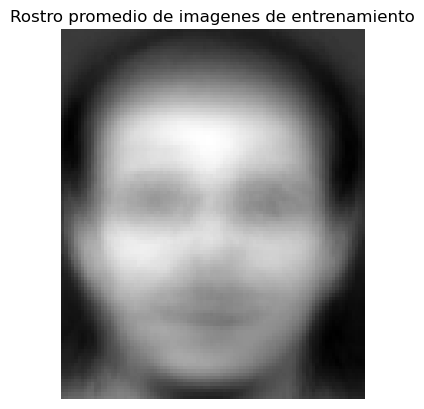

In [16]:
plt.clf()
show_face(X_train.mean(axis=1))
plt.title("Rostro promedio de imagenes de entrenamiento")
plt.show()

## Índice de error mínimo

In [17]:
def best_coordinate(face_sample, m=m, x=x):
    """
    @params
    face_sample: matriz de rostro con los valores del rostro promedio restado
    m = tamaño de columnas de matriz del conjunto de rostros de entrenamiento (la cantidad de diferentes rostros)
    x = matriz de vectores de coordenadas
    """
    err = np.empty(m)
    for i in range(m):
        err[i]=np.linalg.norm(face_sample - x[:,i].reshape(-1,1))
    return np.where(err == err.min())[0]

## Resultados

In [20]:
def resultados(n, train_mat, compare_mat, singular_matrix, r):
    """
    @params
    n: valor entre 0 y 39, rostro de comparacion
    train_mat: matriz de conjunto de rostros de entrenamiento
    compare_mat: matriz de conjunto de rostros de comparacion
    singular_matrix: matrix U resultado de SVD
    r: rango de A
    
    Grafica el rostro a comparar y el rosto que se identifica
    """
    x_sample = singular_matrix[:,:r].T @ compare_mat[:,n].reshape(-1,1)
    plt.clf()
    plt.subplot(1,2,1)
    show_face(compare_mat[:,n])
    plt.title("Rostro Nuevo")
    plt.subplot(1,2,2)
    plt.title("Rostro Identificado")
    show_face(train_mat[:,best_coordinate(x_sample)])
    plt.show()

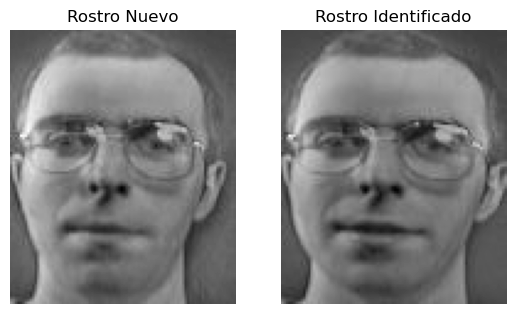

In [26]:
resultados(29, A_train, A_compare, U, r)